# RNA-seq figures #

This notebook assumes differential expression analysis has been run with DESeq2 and stored at a relative path (`"../result/de_result.csv"`)

In [22]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from analysis import (
    get_significant_protein_gene,
    index_gmt_pathways,
    plot_heatmap,
    plot_ma,
    plot_volcano,
)
from common import (
    COMPARISONS,
    DATA_PATH,
    FIGURE_PATH,
    ISG_GENES,
    REFERENCE_PATH,
    RESULT_PATH,
    comparison_genic_expression,
    get_expression_data,
    get_gene_table,
    read_meta,
)
from ridgeplot.colors import ColorEncoder, ColorPalette

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load result data ##

In [5]:
de_table = (
    pd.read_csv(RESULT_PATH / "de_result.csv")
    .rename(columns={"index": "gene_id"})
    .merge(get_gene_table(), on="gene_id", how="left")
    .query("gene_type=='protein_coding'")
    .query("gene_name == gene_name")
)
de_table.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,label,gene_name,gene_type
0,ENSMUSG00000000001,350.026427,0.083420,0.298889,0.279101,0.780168,0.877025,Antibody: α-CCR2 vs control at 5d,Gnai3,protein_coding
1,ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN,Antibody: α-CCR2 vs control at 5d,Pbsn,protein_coding
2,ENSMUSG00000000028,52.862543,0.126077,0.406326,0.310285,0.756344,0.861864,Antibody: α-CCR2 vs control at 5d,Cdc45,protein_coding
4,ENSMUSG00000000037,1.010579,-0.588295,2.648956,-0.222086,0.824247,NaN,Antibody: α-CCR2 vs control at 5d,Scml2,protein_coding
5,ENSMUSG00000000049,3.873065,-0.565701,1.713327,-0.330177,0.741266,0.852566,Antibody: α-CCR2 vs control at 5d,Apoh,protein_coding


## Plot Volcano plot

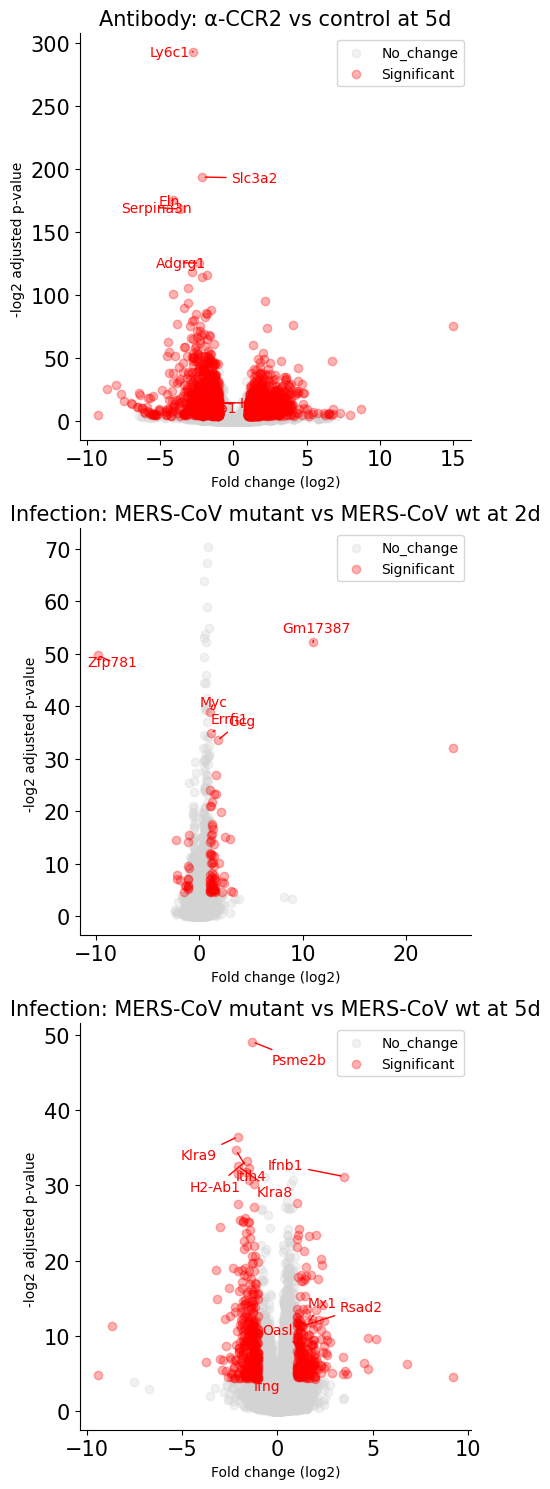

In [6]:
fig = plt.figure(figsize=(5, 15))
for i, (label, lab_tab) in enumerate(de_table.groupby("label")):
    ax = fig.add_subplot(3, 1, i + 1)
    plot_volcano(ax, lab_tab)
    ifn = get_significant_protein_gene(lab_tab).pipe(
        lambda d: d[
            (d["gene_name"].str.contains("Ifn")) | (d["gene_name"].isin(ISG_GENES))
        ]
    )

    def annotate(row):
        xadj = np.random.randint(-4, 4)
        yadj = (
            np.random.randint(1, 4)
            if row.log2FoldChange > 0
            else np.random.randint(-4, -1)
        )
        ax.annotate(
            row.gene_name,
            (row.log2FoldChange, -np.log2(row.padj)),
            (row.log2FoldChange + xadj, -np.log2(row.padj) + yadj),
            color="red",
            arrowprops=dict(arrowstyle="-", color="red"),
        )

    for row in ifn.itertuples():
        annotate(row)

    for row in (
        get_significant_protein_gene(lab_tab)
        .assign(abs_lfc=lambda d: np.abs(d["log2FoldChange"]))
        .nsmallest(5, "padj")
        .itertuples()
    ):
        annotate(row)
    ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(FIGURE_PATH / "volcano_plot.tiff", bbox_inches="tight")

## MA-plots ##

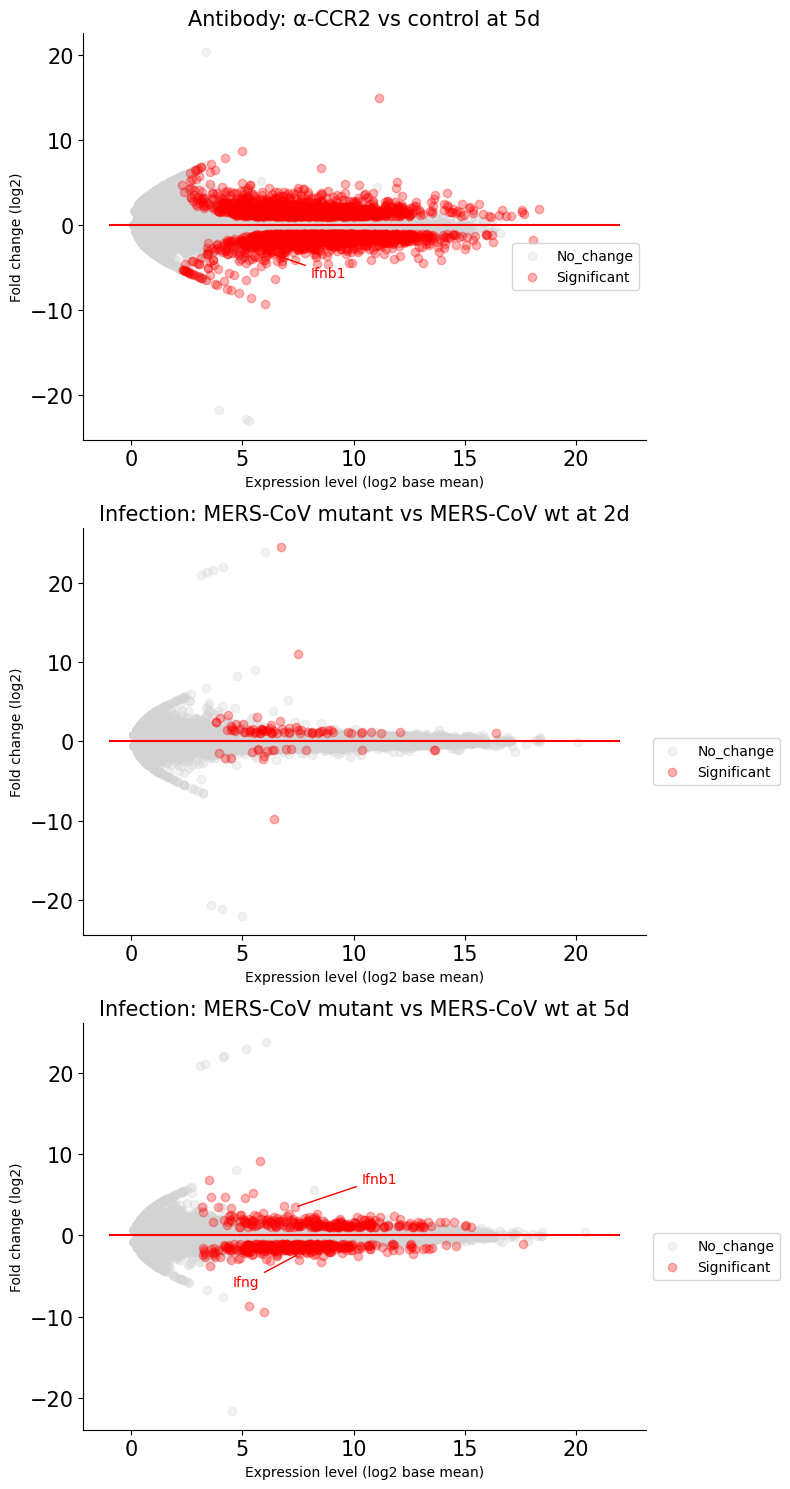

In [7]:
fig = plt.figure(figsize=(8, 15))
for i, (label, lab_tab) in enumerate(de_table.groupby("label")):
    ax = fig.add_subplot(3, 1, i + 1)
    plot_ma(ax, lab_tab)
    ifn = get_significant_protein_gene(
        lab_tab, lfc_threshold=1, padj_threshold=0.05
    ).pipe(
        lambda d: d[
            (d["gene_name"].str.contains("Ifn"))  # | (d["gene_name"].isin(ISG_GENES))
        ]
    )

    def annotate(row):
        xadj = np.random.randint(-4, 4)
        yadj = (
            np.random.randint(1, 4)
            if row.log2FoldChange > 0
            else np.random.randint(-4, -1)
        )
        ax.annotate(
            row.gene_name,
            (np.log2(row.baseMean), row.log2FoldChange),
            (np.log2(row.baseMean) + xadj, row.log2FoldChange + yadj),
            color="red",
            arrowprops=dict(arrowstyle="-", color="red"),
        )

    for row in ifn.itertuples():
        annotate(row)

    for row in (
        get_significant_protein_gene(lab_tab)
        .assign(abs_lfc=lambda d: np.abs(d["log2FoldChange"]))
        .nlargest(5, "abs_lfc")
        .itertuples()
    ):
        #    annotate(row)
        pass
    ax.legend(frameon=True, bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig(FIGURE_PATH / "deplot.tiff", bbox_inches="tight")

## Take a look at Ifn genes ##

In [8]:
get_significant_protein_gene(
    de_table.query(
        f"label == '%s'" % COMPARISONS["comparison_3"].de_label
    ),  # comparison_3 is the 5d analysis
    lfc_threshold=1,
    padj_threshold=0.05,
).pipe(lambda d: d[d["gene_name"].str.contains("Ifn")])

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,label,gene_name,gene_type
101256,ENSMUSG00000048806,165.872372,3.485311,0.483964,7.201587,5.951588e-13,4.152289e-10,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnb1,protein_coding
102793,ENSMUSG00000055170,188.373449,-2.257538,0.666225,-3.388552,7.026281e-04,8.866068e-03,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifng,protein_coding


In [9]:
ifn = (
    de_table.query(f"label == '%s'" % COMPARISONS["comparison_3"].de_label)
    .pipe(lambda d: d[d["gene_name"].str.contains("Ifn")])
    .sort_values("padj")
)
ifn.to_csv(DATA_PATH / "ifn.csv", index=False)
ifn.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,label,gene_name,gene_type
101256,ENSMUSG00000048806,165.872372,3.485311,0.483964,7.201587,5.951588e-13,4.152289e-10,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnb1,protein_coding
102793,ENSMUSG00000055170,188.373449,-2.257538,0.666225,-3.388552,7.026281e-04,8.866068e-03,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifng,protein_coding
90862,ENSMUSG00000022971,3305.081281,-0.182735,0.102685,-1.779576,7.514543e-02,2.231867e-01,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnar2,protein_coding
104347,ENSMUSG00000062157,233.991983,0.353001,0.243046,1.452405,1.463892e-01,3.468563e-01,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnlr1,protein_coding
103660,ENSMUSG00000059128,11.597159,2.368757,1.784348,1.327520,1.843369e-01,4.023476e-01,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnl2,protein_coding


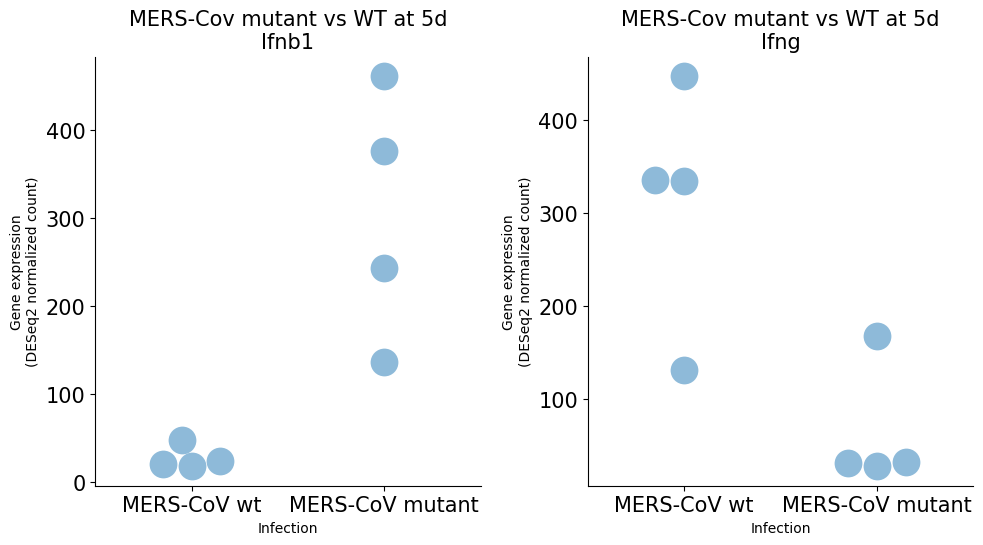

In [11]:
fig = plt.figure(figsize=(10, 10))

for i, (gene_name, comparison) in enumerate(
    [
        ("Ifnb1", "comparison_3"),
        ("Ifng", "comparison_3"),
    ]  # , ("Ifnl2", "comparison_3"), ("Ifna4", "comparison_3")]
):
    ax = fig.add_subplot(2, 2, i + 1)
    gene_data = comparison_genic_expression([gene_name], comparison)
    sns.swarmplot(data=gene_data, x="Infection", y="value", ax=ax, s=20, alpha=0.5)
    ax.set_ylabel("Gene expression\n(DESeq2 normalized count)")
    ax.set_title(f"{COMPARISONS[comparison].label}\n{gene_name}", size=15)
sns.despine()
fig.tight_layout()
fig.savefig(FIGURE_PATH / "gene_expr_plot.tiff", bbox_inches="tight")

In [12]:
with pd.ExcelWriter(RESULT_PATH / "DE.xlsx") as writer:
    for lab, lab_df in de_table.groupby("label"):
        lab_df.to_excel(writer, sheet_name=lab.replace(":", "__"))

/home/wu58/code/miniconda3/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Gene set enrichment # 

This assumes a `m5.go.v2022.1.Mm.symbols.gmt` (from [here](https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2022.1.Mm/)) is downloaded at `../data`

In [13]:
import gseapy as gp

gmt_file = DATA_PATH / "m5.go.v2022.1.Mm.symbols.gmt"

In [14]:
COMPARISONS["comparison_1"].de_label

'Antibody: α-CCR2 vs control at 5d'

In [15]:
def get_pathways(comparison: str = "comparison_1"):
    comparison_df = de_table[de_table["label"] == COMPARISONS[comparison].de_label]

    def get_enrich(gene_change_direction="increase"):
        if gene_change_direction == "increase":
            query_filter = "log2FoldChange > 0"
        elif gene_change_direction == "decrease":
            query_filter = "log2FoldChange < 0"
        else:
            raise ValueError(f"{gene_change_direction} is not accepted")

        gene_list = (
            get_significant_protein_gene(
                comparison_df, lfc_threshold=1, padj_threshold=0.05
            ).query(query_filter)
        )["gene_name"].tolist()
        background_gene = comparison_df["gene_name"]

        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets=[gmt_file.as_posix()],
            organism="Mouse",
            outdir=None,
            background=background_gene,
            verbose=True,
            cutoff=0.05,
        )

        return (
            enr.res2d.sort_values("Adjusted P-value")
            .assign(label=COMPARISONS[comparison].de_label)
            .assign(gene_change=f"{gene_change_direction} expression")
        )

    return pd.concat(map(get_enrich, ["increase", "decrease"]))

In [16]:
de_pathway_df = pd.concat(get_pathways(f"comparison_{i}") for i in range(1, 4))
de_pathway_df.head()

2023-03-11 20:42:06,191 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-03-11 20:42:06,335 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-03-11 20:42:12,729 [INFO] Done.
2023-03-11 20:42:12,758 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-03-11 20:42:12,836 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-03-11 20:42:18,834 [INFO] Done.
2023-03-11 20:42:18,868 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-03-11 20:42:18,946 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-03-11 20:42:20,628 [INFO] Done.
2023-03-11 20:42:20,654 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-03-11 20:42:20,737 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-03-11 20:42:21,323 [INFO] Done.
2023-03-11 20:42:21,352 [INFO] User defi

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,label,gene_change
5816,m5.go.v2022.1.Mm.symbols.gmt,GOCC_CHROMOSOME,161/1259,6.856549e-13,5.184236e-09,1.851045,Birc5;Prdm10;Ss18;Septin6;Baz1a;Sgo1;Hnrnpa2b1...,Antibody: α-CCR2 vs control at 5d,increase expression
1815,m5.go.v2022.1.Mm.symbols.gmt,GOBP_MICROTUBULE_CYTOSKELETON_ORGANIZATION,97/632,1.501683e-12,5.677113e-09,2.193847,Ttbk2;Birc5;Ss18;Cep295;Cep290;Sgo1;Cfap65;Tbc...,Antibody: α-CCR2 vs control at 5d,increase expression
1811,m5.go.v2022.1.Mm.symbols.gmt,GOBP_MICROTUBULE_BASED_PROCESS,127/939,5.191308e-12,1.308383e-08,1.942835,Ttbk2;Birc5;Lca5l;Ss18;Cep295;Cep290;Sgo1;Cfap...,Antibody: α-CCR2 vs control at 5d,increase expression
6094,m5.go.v2022.1.Mm.symbols.gmt,GOCC_MICROTUBULE_CYTOSKELETON,158/1289,3.295057e-11,6.228481e-08,1.767935,Ttbk2;Cpeb1;Daam1;Birc5;C2cd5;Trappc14;Ss18;Ce...,Antibody: α-CCR2 vs control at 5d,increase expression
559,m5.go.v2022.1.Mm.symbols.gmt,GOBP_CELL_CYCLE,195/1765,1.199482e-09,1.813857e-06,1.597295,Insm1;Cpeb1;Birc5;Zfp318;Cep295;Septin6;Sgo1;C...,Antibody: α-CCR2 vs control at 5d,increase expression


In [17]:
pathway_index = index_gmt_pathways(gmt_file=gmt_file)

INFO:/raid/home/wu58/projects/rna-seq/mouse/code/analysis.py:Indexed 10560 pathways


/tmp/ipykernel_1647744/16627451.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  Term=lambda d: d["Term"]
/home/wu58/code/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


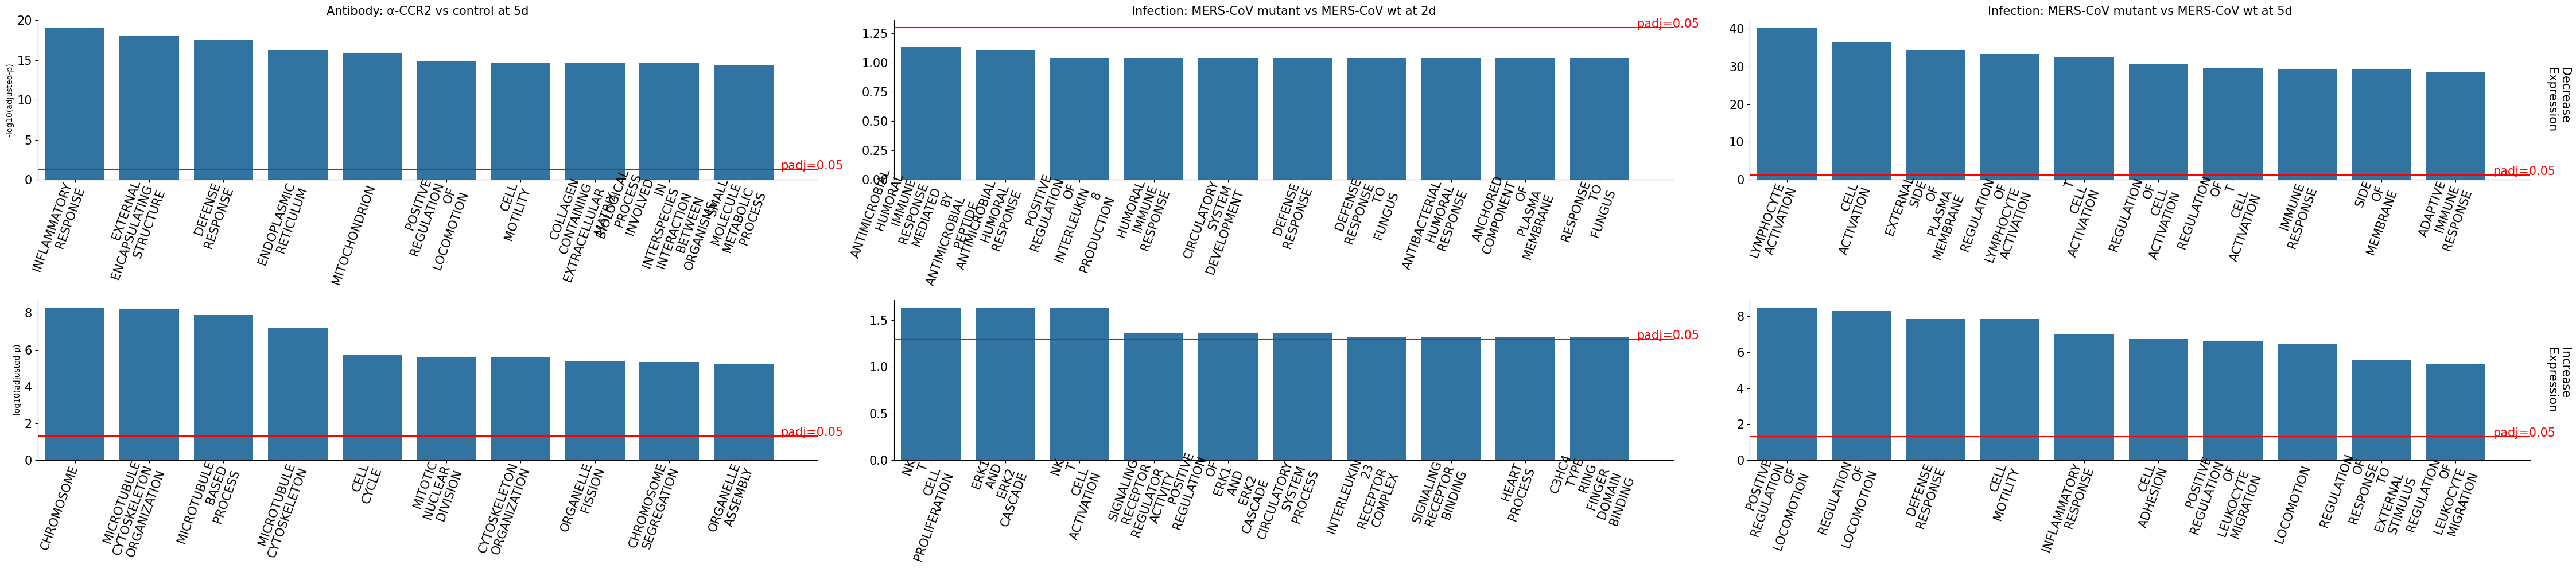

In [18]:
p = sns.FacetGrid(
    data=(
        de_pathway_df.groupby(["label", "gene_change"])
        .apply(lambda d: d.nsmallest(10, "Adjusted P-value"))
        .assign(log_padj=lambda d: -np.log10(d["Adjusted P-value"]))
        # .assign(label=lambda d: d['label'].str.replace(':|vs', '\nvs\n'))
        .assign(
            gene_change=lambda d: d["gene_change"].str.replace(" ", "\n").str.title()
        )
        .assign(
            Term=lambda d: d["Term"]
            .str.replace("^GO[A-Z][A-Z]_", "")
            .str.replace("_", "\n")
        )
    ),
    row="gene_change",
    col="label",
    sharey=False,
    margin_titles=True,
    sharex=False,
    height=5,
    aspect=3,
)
p.set_titles(row_template="{row_name}", col_template="{col_name}")
p.map(sns.barplot, "Term", "log_padj")
p.set_axis_labels("", "-log10(adjusted-p)")
for ax in p.fig.axes:
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=70,
        ha="right",
        va="center",
        rotation_mode="anchor",
    )
    ax.hlines(y=-np.log10(0.05), xmin=-20, xmax=20, color="red")
    ax.text(9.5, 1.3, "padj=0.05", color="red", fontsize=15)
p.set(xlim=(-0.5, 10))
p.fig.tight_layout()
p.savefig(FIGURE_PATH / "pathways.tiff", bbox_inches="tight")

In [19]:
with pd.ExcelWriter(RESULT_PATH / "differential_pathways.xlsx") as writer:
    for (label, gc), data in de_pathway_df.assign(
        url=lambda d: d["Term"].map(lambda x: pathway_index[x].description_url)
    ).groupby(["label", "gene_change"]):
        data.to_excel(
            writer, sheet_name=f"{gc} {label.replace('α', 'a').replace(':',' ')}"
        )

/home/wu58/code/miniconda3/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Heatmap #

gene_list = "Chil3;Cd163;Cxcl13;Thbs1;Il4ra;Serpine1;F3;Nt5e;Tnfsf18;Adam8;C5ar1;Serpina3n;Ccn4;Bdkrb1;Adamts12;Orm1;Sphk1;Sema7a;Tnc;Sele;Epha2;Selp;Apod;Pla2g7;Timp1;Ldlr;Ptges;Ace;Il1r2;Trem1;Il23a;Tlr13"
gene_list = gene_list.split(";")
p = plot_heatmap(
    de_table,
    "comparison_3",
    gene_list=gene_list,
    figsize=(8, 20),
    diff_expr_gene_only=True,
    zscore_normalize=True,
)
p.savefig(FIGURE_PATH / "5d_heatmap_upregulated.tiff", bbox_inches="tight")

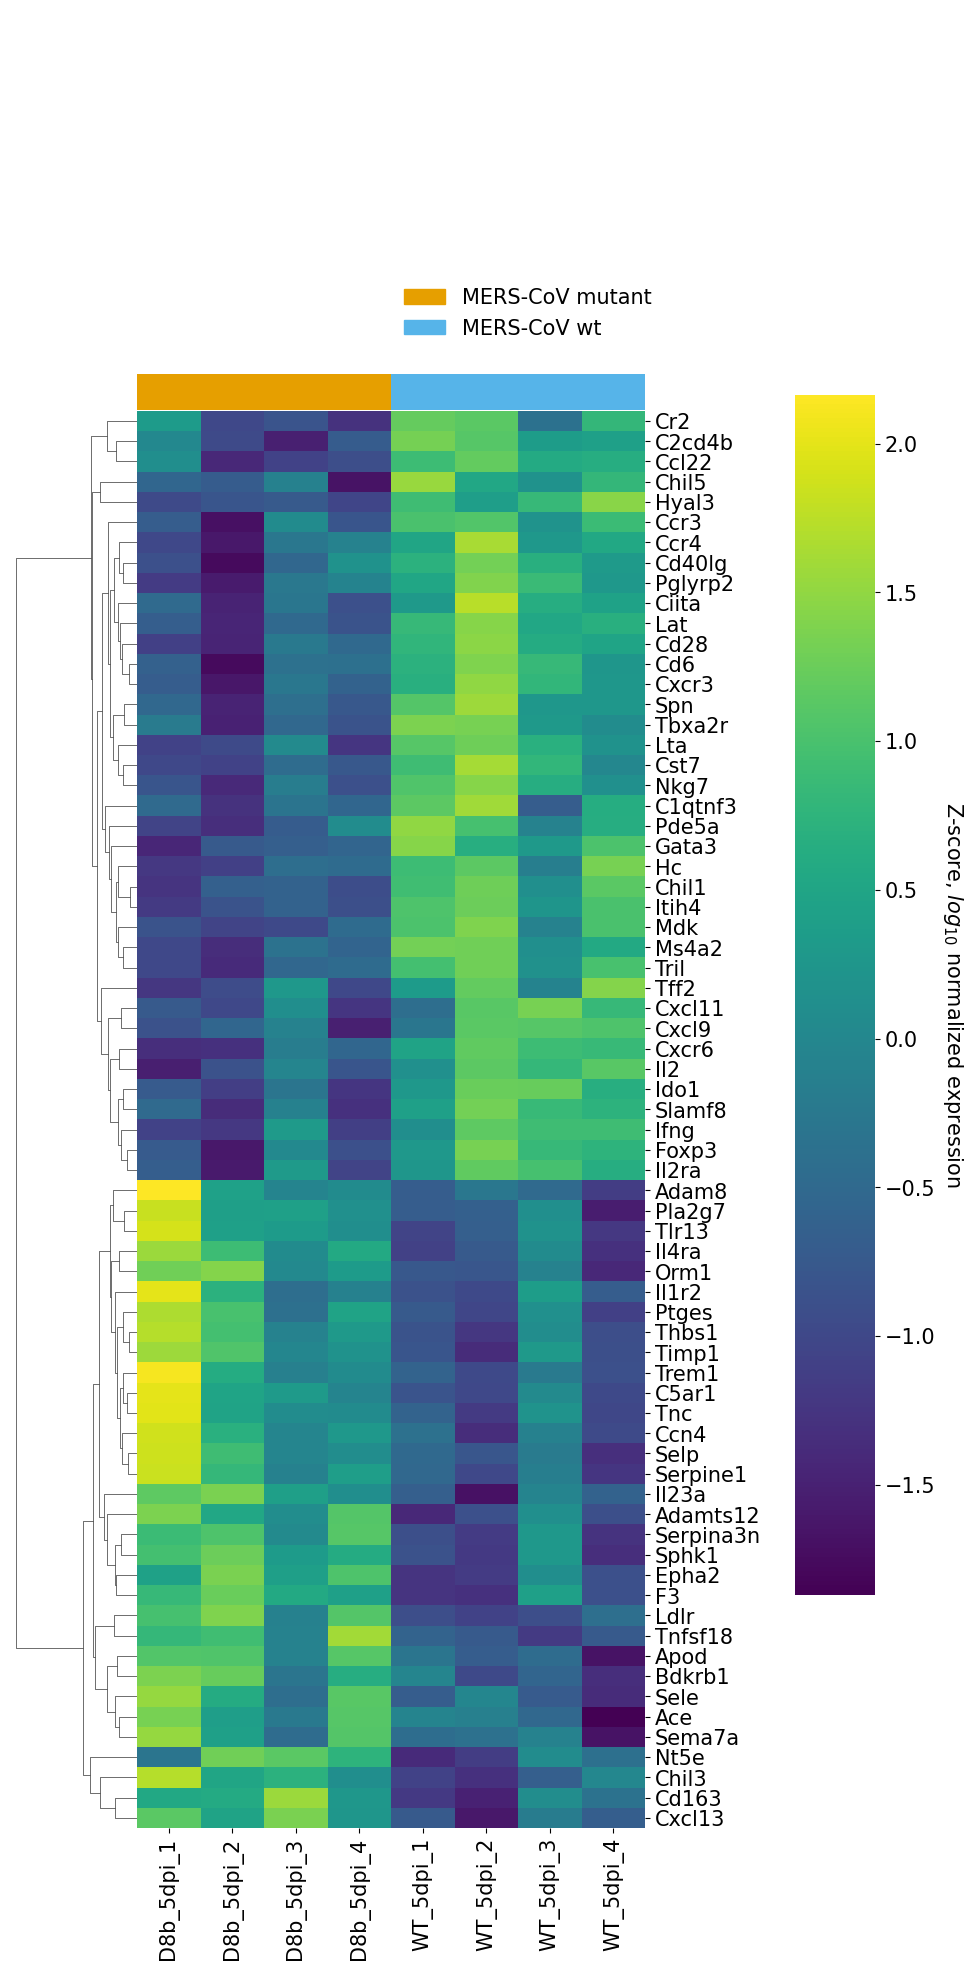

In [28]:
p = plot_heatmap(
    de_table,
    "comparison_3",
    gene_list=pathway_index["GOBP_INFLAMMATORY_RESPONSE"].genes,
    figsize=(8, 20),
    diff_expr_gene_only=True,
    zscore_normalize=True,
)
p.savefig(FIGURE_PATH / "5d_heatmap_inflammatory_response.tiff", bbox_inches="tight")

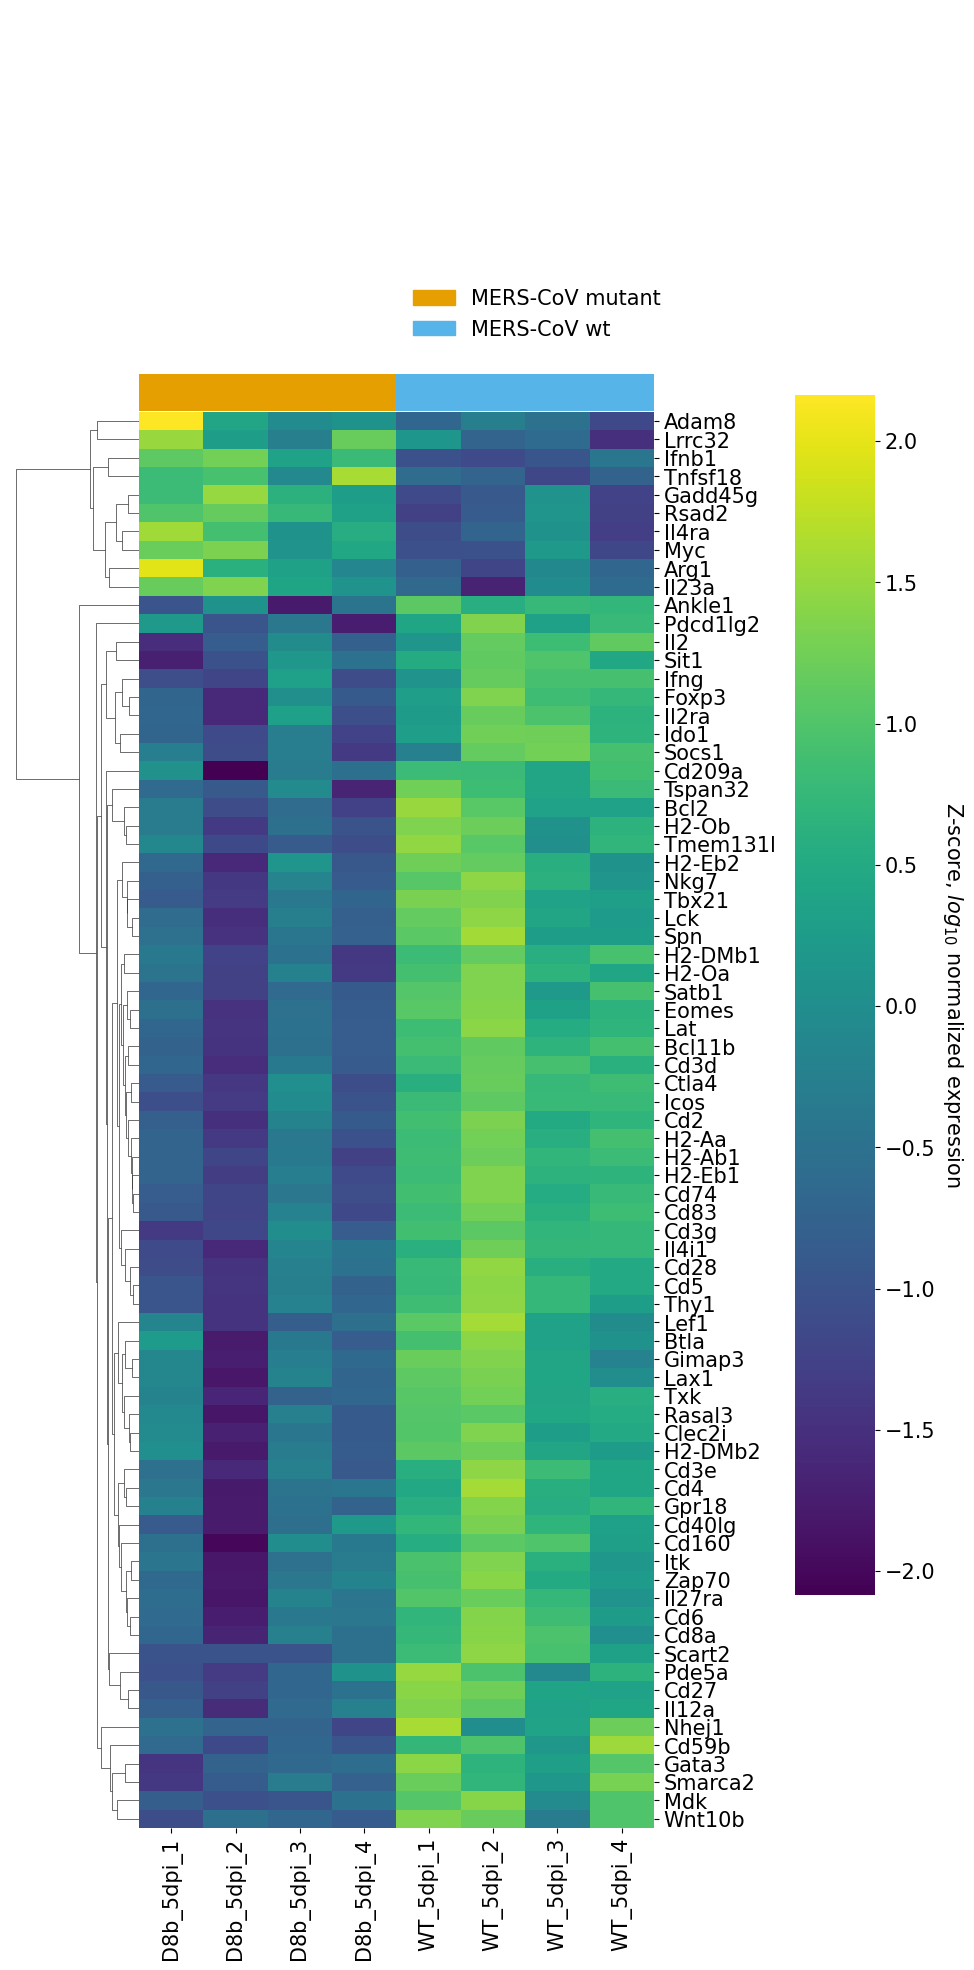

In [29]:
p = plot_heatmap(
    de_table,
    "comparison_3",
    gene_list=pathway_index["GOBP_T_CELL_ACTIVATION"].genes,
    figsize=(8, 20),
    diff_expr_gene_only=True,
    zscore_normalize=True,
)
p.savefig(FIGURE_PATH / "5d_heatmap_tcell_activation.tiff", bbox_inches="tight")

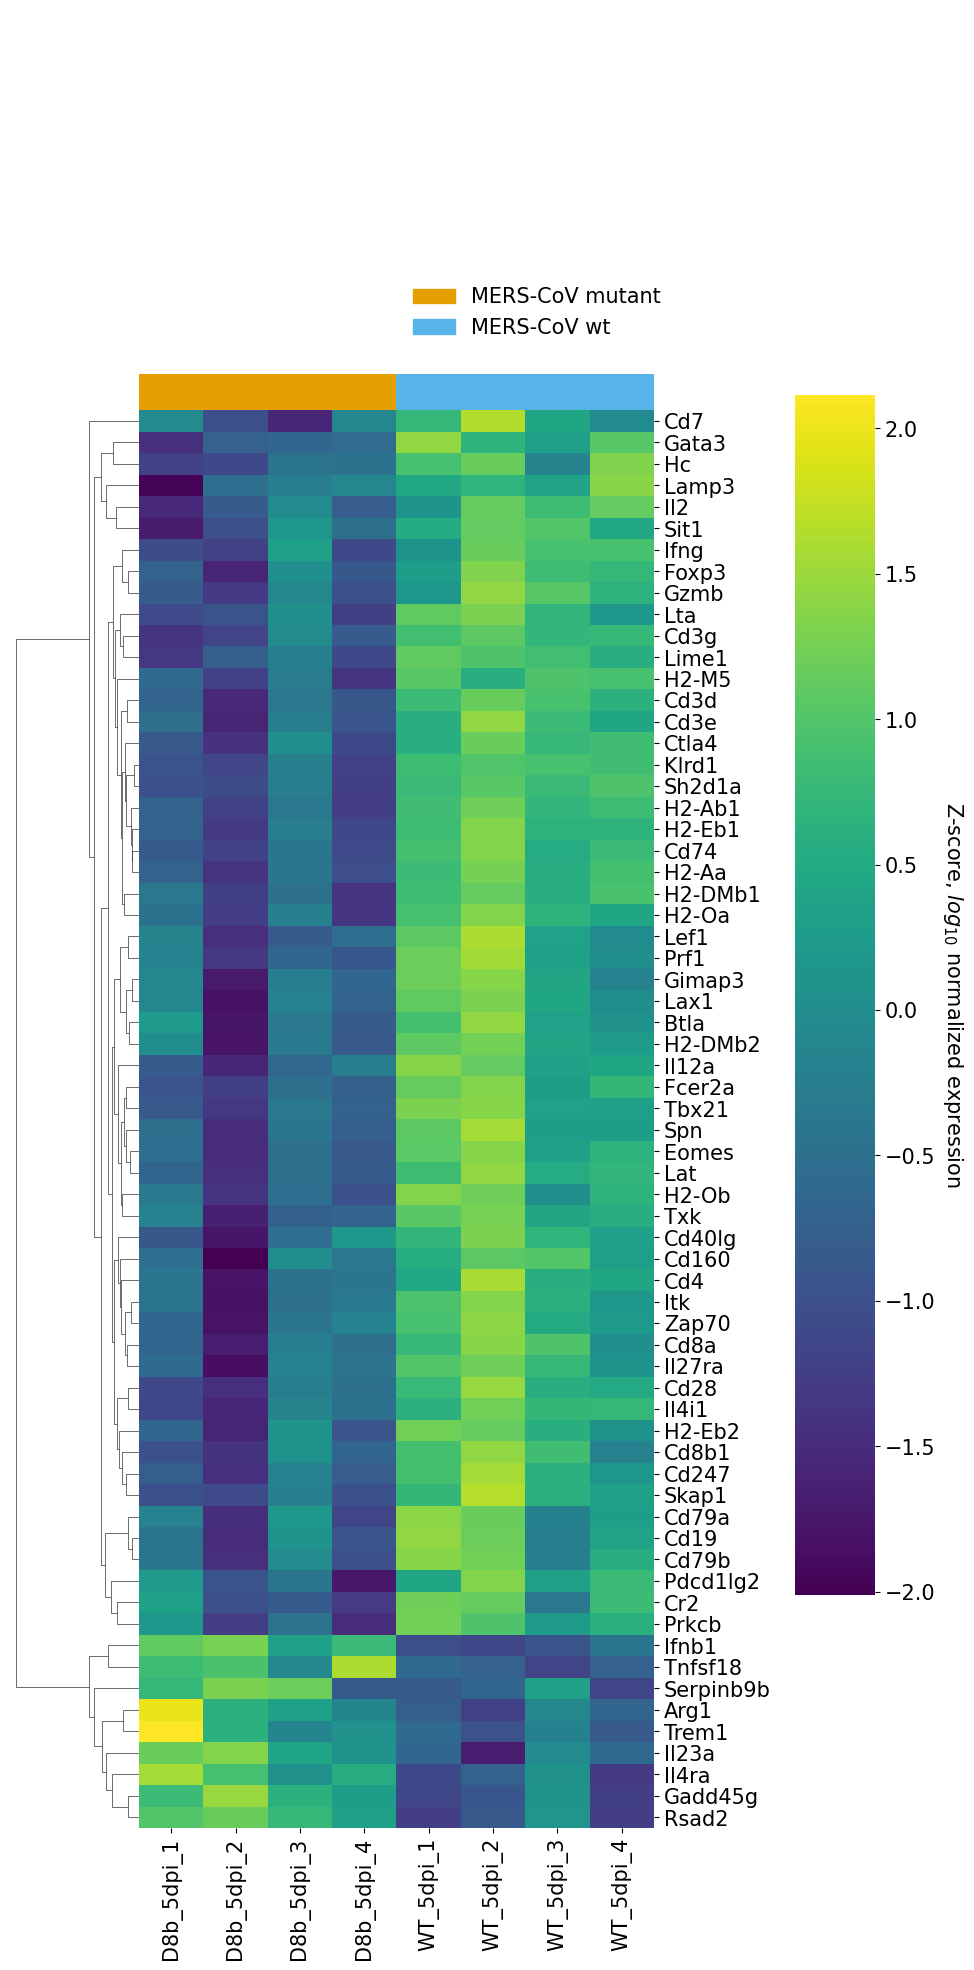

In [30]:
p = plot_heatmap(
    de_table,
    "comparison_3",
    gene_list=pathway_index["GOBP_ADAPTIVE_IMMUNE_RESPONSE"].genes,
    figsize=(8, 20),
    diff_expr_gene_only=True,
    zscore_normalize=True,
)
p.savefig(FIGURE_PATH / "5d_heatmap_adaptive_immune_response.tiff", bbox_inches="tight")

# Get Z-score dataframe #

In [175]:
from sklearn.preprocessing import StandardScaler

gene_list = de_table["gene_name"].unique().tolist()

norm_df = (
    comparison_genic_expression(gene_list, "comparison_3", allow_missing=True)
    .groupby(["sample_id", "gene_name"], as_index=False)
    .agg({"value": "sum"})
    .pipe(pd.pivot, index="gene_name", columns="sample_id", values="value")
    .pipe(
        lambda d: pd.DataFrame(
            np.log(d + 1).pipe(StandardScaler().fit_transform),
            index=d.index,
            columns=d.columns,
        )
    )
    .reset_index()
)
norm_df.to_csv(RESULT_PATH / "z_score_df.csv", index=False)